# TTS
[Source](https://github.com/snakers4/silero-models)

## Import

In [ ]:
import torch # Model etc
!pip install omegaconf
from omegaconf import OmegaConf

from IPython.display import Audio # Audio

## Model

In [ ]:
# Setting
language = 'en'
model_id = 'v3_en'
sample_rate = 48000
# Male Speaker: en_13, en_15, en_17, en_19 *
# Female Speaker: en_0, en_5, en_10 *, en_11 *, en_12 *, en_14, en_18 *
speaker_m = 'en_19'
speaker_f = 'en_18'
device = torch.device('cpu')

# Load Model
model, example_text = torch.hub.load(repo_or_dir='snakers4/silero-models',
                                     model='silero_tts',
                                     language=language,
                                     speaker=model_id)
model.to(device)  # gpu or cpu

## Audio

In [ ]:
text = "Hello, I am demonstrating this app. As you can see, this app is able to translate sign language into text and voice."
# Male Audio
audio_m = model.apply_tts(text=text,
                          speaker=speaker_m,
                          sample_rate=sample_rate)

display(Audio(audio_m, rate=sample_rate))

In [ ]:
# Female Audio
audio_f = model.apply_tts(text=text,
                          speaker=speaker_f,
                          sample_rate=sample_rate)

display(Audio(audio_f, rate=sample_rate))

## Save Model

In [ ]:
# Save ke JSON
import json

# Male Speaker Model
model_config_m = {
  'repo_or_dir': 'snakers4/silero-models',
  "language": language,
  "model_id": model_id,
  "sample_rate": sample_rate,
  "speaker": speaker_m
}

with open('/kaggle/working/model_config_m.json', 'w') as f:
  json.dump(model_config_m, f)

model_info = {
    'repo_or_dir': 'snakers4/silero-models',
    'model': 'silero_tts',
    'language': language,
    'speaker': model_id
}

with open('silero_tts_model_info.json', 'w') as f:
    json.dump(model_info, f)

In [ ]:
# Save ke biner
model.save_random_voice('/kaggle/working/silero_tts_model.pt')

In [ ]:
import tensorflow as tf
import tensorflow_text as text
import tensorflow_io as tfio

In [ ]:
# Unduh model TFLite
model_url = "https://storage.googleapis.com/download.tensorflow.org/models/tflite/task_library/text_to_speech/en/lite-model_fastspeech2_en_1.tflite"
model_path = tf.keras.utils.get_file("tts_model.tflite", model_url)

# Fungsi untuk mengubah teks menjadi audio
def text_to_speech(text, model_path):
    # Load model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Preprocess text
    input_text = text.normalize_utf8(text)
    input_ids = text.wordpiece_tokenizer(input_text)

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], tf.expand_dims(input_ids, 0))

    # Run inference
    interpreter.invoke()

    # Get output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Convert to audio
    audio = tfio.audio.encode_wav(output_data, rate=22050)
    
    return audio

# Sign Language

## Persiapan & Proses Video

### API Config

In [1]:
import os
import json

# Membuat direktori .kaggle dan memindahkan file API ke dalamnya
os.makedirs('/root/.kaggle/', exist_ok=True)
!cp /kaggle/input/tancap-app-dataset/API.json /root/.kaggle/kaggle.json

# Mengatur izin untuk file kaggle.json
os.chmod('/root/.kaggle/kaggle.json', 600)

### Unduh [Dataset WLASL](https://www.kaggle.com/datasets/risangbaskoro/wlasl-processed)

In [ ]:
# Unduh dataset WLASL
!kaggle datasets download -d risangbaskoro/wlasl-processed

# Ekstrak dataset yang telah diunduh
!unzip wlasl-processed.zip -d wlasl-processed

### Memuat Video dari Dataset

In [ ]:
import cv2
!pip install mediapipe
import mediapipe as mp
import os
from matplotlib import pyplot as plt
import shutil

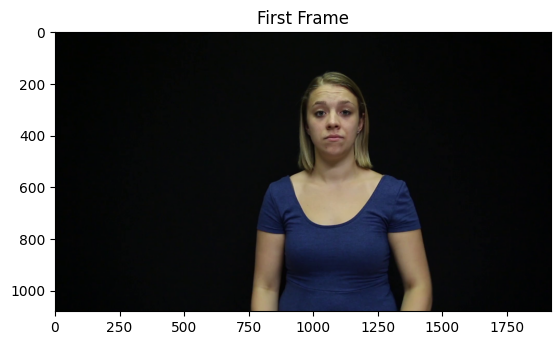

In [4]:
video_folder = 'wlasl-processed/videos/'
video_path = os.path.join(video_folder, '00946.mp4') 

cap = cv2.VideoCapture(video_path)
if cap.isOpened():
    ret, frame = cap.read()
    if ret:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title('First Frame')
        plt.show()
    cap.release()

### Proses video dengan MediaPipe

In [8]:
import cv2
import mediapipe as mp
import os
from IPython.display import HTML
from base64 import b64encode

# Inisialisasi MediaPipe Hand model
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Fungsi untuk deteksi dan menggambar landmark dengan MediaPipe
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Konversi warna BGR ke RGB
    image.flags.writeable = False                  # Membuat gambar tidak dapat ditulis untuk meningkatkan kinerja
    results = model.process(image)                 # Membuat prediksi dengan model
    image.flags.writeable = True                   # Membuat gambar dapat ditulis kembali
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Konversi warna RGB ke BGR
    return image, results

# Fungsi untuk menggambar landmark yang sudah diatur stylenya
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(
        image, results.face_landmarks, mp.solutions.face_mesh.FACEMESH_TESSELATION,
        mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
        mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1)
    )
    # Draw pose connections
    mp_drawing.draw_landmarks(
        image, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=2),
        mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2)
    )
    # Draw left hand connections
    mp_drawing.draw_landmarks(
        image, results.left_hand_landmarks, mp.solutions.hands.HAND_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=2),
        mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2)
    )
    # Draw right hand connections
    mp_drawing.draw_landmarks(
        image, results.right_hand_landmarks, mp.solutions.hands.HAND_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
        mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
    )

In [9]:
# Pastikan folder labeling sudah ada
labeling_folder = '/kaggle/working/labeling'
os.makedirs(labeling_folder, exist_ok=True)

# Path video yang akan diolah
video_path = '/kaggle/working/wlasl-processed/videos/00946.mp4'
cap = cv2.VideoCapture(video_path)

if cap.isOpened():
    # Mendapatkan informasi video asli
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Mendefinisikan codec dan pembuat video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Menggunakan codec mp4v
    output_video_path = os.path.join(labeling_folder, 'output_video23.mp4')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Inisialisasi Holistic model
    mp_drawing = mp.solutions.drawing_utils
    mp_holistic = mp.solutions.holistic

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Proses frame untuk deteksi dan gambar landmark
            image, results = mediapipe_detection(frame, holistic)
            draw_styled_landmarks(image, results)

            # Tulis frame yang telah diproses ke video
            out.write(image)

    # Melepaskan capture video dan pembuat video
    cap.release()
    out.release()

    print(f"Video berhasil disimpan di: {output_video_path}")

else:
    print("Error: Could not open video.")

W0000 00:00:1718952195.362686     186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718952195.393494     186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718952195.394944     187 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718952195.395040     186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718952195.396674     185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718952195.406100     185 inference_feedback_manager.cc:114] Feedback manager 

Video berhasil disimpan di: /kaggle/working/labeling/output_video23.mp4


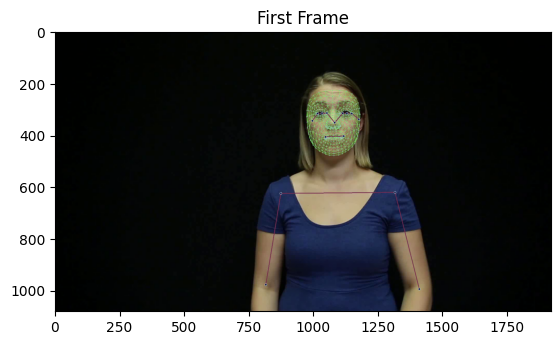

In [10]:
video_folder = 'wlasl-processed/videos/'
video_path = '/kaggle/working/labeling/output_video23.mp4'

cap = cv2.VideoCapture(video_path)
if cap.isOpened():
    ret, frame = cap.read()
    if ret:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title('First Frame')
        plt.show()
    cap.release()

### Cari kata-kata
Mengingat kita tidak memiliki sumber daya yang cukup.  
Kami hanya akan menggunakan kalimat berikut untuk traning model pertama:  
> Hello, I am demonstrating this app. 
As you can see, this app is able to translate sign language into text and voice.

In [19]:
import json

# Path ke file JSON
json_path = '/kaggle/working/wlasl-processed/WLASL_v0.3.json'

# Kata-kata yang ingin dicari
search_words = ["hello", "i","i'm", "demonstrate", "this", "program", "app", # tidak ada i'm jadi menggunakan i. tidak ada application jadi menggunakan program
                "you", "can", "see", "this", "program", "is", "able", "to", "translate", "sign", "language", "to", "into", "text", "and", "voice"]

# Membaca file JSON
with open(json_path, 'r') as file:
    data = json.load(file)

# Hasil pencarian
search_results = {word: [] for word in search_words}
actions = []

# Iterasi melalui data JSON dan mencari kata-kata
for entry in data:
    gloss = entry.get("gloss")
    if gloss in search_words:
        instances = entry.get("instances")
        if instances:
            search_results[gloss].extend(instances)
            actions.append(gloss)

# Menampilkan hasil pencarian dan daftar actions
for word, instances in search_results.items():
    if instances:
        video_ids = ', '.join([str(instance['video_id']) for instance in instances])
        print(f"Word: {word}")
        print(f"  - Video ID: {video_ids}")
    else:
        print(f"Word: {word} tidak ditemukan")
    print("\n")

print("Actions list:")
print(actions)

Word: hello
  - Video ID: 27171, 70017, 68236, 27180, 67755, 27181, 27182, 27183, 27184, 27172, 27173, 27175, 27177


Word: i
  - Video ID: 28557, 66047, 28789, 28790, 28791, 28793, 28794


Word: i'm tidak ditemukan


Word: demonstrate
  - Video ID: 15473, 15474, 15475, 15476, 15477, 15478, 15479, 15480, 15481


Word: this
  - Video ID: 58070, 69507, 58077, 58079, 66628, 58080, 58072, 58074


Word: program
  - Video ID: 44828, 44837, 66337, 44829, 44830, 44831, 44832, 44833, 44834, 44835, 44836


Word: app tidak ditemukan


Word: you
  - Video ID: 64351, 69547, 64384, 64385, 64386, 64387, 64388, 64379, 67015, 64389, 64390, 64391, 64380, 64381, 64382, 64383


Word: can
  - Video ID: 69257, 65294, 08950, 08951, 08952, 08953, 08955, 08935, 08936, 08937, 08938, 08939, 08942, 67465, 08944, 08945, 08946, 08947, 08948, 08949


Word: see
  - Video ID: 50107, 69460, 68444, 50120, 67178, 50122, 50123, 50125, 50126, 50127, 50128


Word: is tidak ditemukan


Word: able
  - Video ID: 00374, 00376, 

Seperti yang terlihat bahwa bahasa isyarat itu tidak lengkap. Sehingga ketika sudah mendapatkan arti dari bahasa isyarat, perlu di kelola ulang bahasa nya.

## Memberi landmark pada video
Kata-kata yang ingin dicari tadi, diberikan landmark dengan fungsi dibawah

In [23]:
# Fungsi untuk proses video dan ekstraksi key points
def process_videos(labeling_folder, video_ids, words, data_path):
    # Pastikan folder labeling dan data_path sudah ada
    os.makedirs(labeling_folder, exist_ok=True)
    os.makedirs(data_path, exist_ok=True)

    # Inisialisasi model Holistic dan drawing utils
    mp_drawing = mp.solutions.drawing_utils
    mp_holistic = mp.solutions.holistic
    mp_face_mesh = mp.solutions.face_mesh

    # Ukuran target untuk normalisasi video
    target_width, target_height = 640, 480

    # Inisialisasi Holistic model
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        for video_id, word in zip(video_ids, words):
            # Path video yang akan diolah
            video_path = f'/kaggle/working/wlasl-processed/videos/{video_id}.mp4'
            cap = cv2.VideoCapture(video_path)

            if cap.isOpened():
                # Mendapatkan informasi video asli
                fps = int(cap.get(cv2.CAP_PROP_FPS))

                # Mendefinisikan codec dan pembuat video
                fourcc = cv2.VideoWriter_fourcc(*'mp4v')

                # Pastikan folder kata sudah ada di labeling_folder
                word_labeling_path = os.path.join(labeling_folder, word)
                os.makedirs(word_labeling_path, exist_ok=True)

                output_video_path = os.path.join(word_labeling_path, f'{word}_{video_id}.mp4')
                out = cv2.VideoWriter(output_video_path, fourcc, fps, (target_width, target_height))

                # List untuk menyimpan data keypoints
                keypoints_data = []

                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break

                    # Ubah ukuran frame menjadi ukuran target
                    frame = cv2.resize(frame, (target_width, target_height))

                    # Proses frame untuk deteksi dan gambar landmark
                    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Mediapipe menggunakan RGB
                    results = holistic.process(image)
                    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
                    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_CONTOURS)
                    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
                    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

                    # Ekstraksi key points dari hasil deteksi
                    keypoints = extract_keypoints(results)
                    keypoints_data.append(keypoints)

                    # Tulis frame yang telah diproses ke video
                    out.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

                # Melepaskan capture video dan pembuat video
                cap.release()
                out.release()

                print(f"Video berhasil disimpan di: {output_video_path}")

                # Simpan keypoints ke file .npy
                keypoints_array = np.array(keypoints_data)

                # Pastikan folder kata sudah ada di data_path
                word_data_path = os.path.join(data_path, word)
                os.makedirs(word_data_path, exist_ok=True)

                keypoints_path = os.path.join(word_data_path, f"kp_{video_id}.npy")
                np.save(keypoints_path, keypoints_array)
                print(f"Keypoints berhasil disimpan di: {keypoints_path}")

            else:
                print(f"Error: Could not open video {video_path}")

### Ekstrak Nilai koordinat landmark

In [14]:
import numpy as np

# Fungsi untuk ekstraksi key points
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [103]:
# Kata-kata yang ingin dicari
search_words = ["hello", "i", "i'm", "demonstrate", "this", "program", "app",
                "you", "can", "see", "this", "program", "is", "able", "to", 
                "translate", "sign", "language", "into", "text", "and", "voice"]

# Membaca file JSON (ganti dengan path file JSON Anda)
json_path = '/kaggle/working/wlasl-processed/WLASL_v0.3.json'
with open(json_path, 'r') as file:
    data = json.load(file)

# Hasil pencarian
search_results = {word: [] for word in search_words}

# Iterasi melalui data JSON dan mencari kata-kata
for entry in data:
    gloss = entry.get("gloss")
    if gloss in search_words:
        search_results[gloss].extend(entry.get("instances"))

# Mengumpulkan video ID dan kata yang sesuai untuk pemrosesan
video_ids = []
words = []

for word, instances in search_results.items():
    if instances:
        for instance in instances:
            video_ids.append(instance['video_id'])
            words.append(word)

In [ ]:
# Path folder untuk menyimpan video yang sudah diberi label
labeling_folder = '/kaggle/working/landmark'

# Path folder untuk menyimpan keypoints
data_path = '/kaggle/working/DATA_PATH'

# Memproses video dan ekstraksi key points
process_videos(labeling_folder, video_ids, words, data_path)

### Zip hasilnya dan download

In [26]:
import zipfile
import os

# Fungsi untuk membuat zip
def create_zip(folder_name, zip_file_name):
    with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_name):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_name))

                
# Landmark VIDEO
folder_name = '/kaggle/working/landmark'

zip_file_name = '/kaggle/working/landmark.zip'

create_zip(folder_name, zip_file_name)


# Data key points (koordinat) npy
folder_name = '/kaggle/working/DATA_PATH'

zip_file_name = '/kaggle/working/DATA_PATH.zip'

create_zip(folder_name, zip_file_name)

## Preprocessing Data

In [28]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [29]:
actions

['can',
 'language',
 'you',
 'sign',
 'voice',
 'hello',
 'and',
 'program',
 'see',
 'to',
 'translate',
 'demonstrate',
 'able',
 'this',
 'i',
 'text']

In [30]:
# Buat label map
label_map = {label: num for num, label in enumerate(actions)}
print(label_map)

# Parameters
sequence_length = 30  # Atur panjang sequence sesuai kebutuhan

sequences, labels = [], []

{'can': 0, 'language': 1, 'you': 2, 'sign': 3, 'voice': 4, 'hello': 5, 'and': 6, 'program': 7, 'see': 8, 'to': 9, 'translate': 10, 'demonstrate': 11, 'able': 12, 'this': 13, 'i': 14, 'text': 15}


In [31]:
# Kumpulkan sequences dari file .npy
for action in actions:
    action_path = os.path.join(data_path, action)
    if os.path.exists(action_path):
        for npy_file in os.listdir(action_path):
            if npy_file.endswith('.npy'):
                npy_path = os.path.join(action_path, npy_file)
                keypoints_sequence = np.load(npy_path)

                # Membagi keypoints_sequence menjadi sequences dengan panjang tertentu
                num_sequences = len(keypoints_sequence) // sequence_length
                for seq in range(num_sequences):
                    start_idx = seq * sequence_length
                    end_idx = start_idx + sequence_length
                    window = keypoints_sequence[start_idx:end_idx]

                    if len(window) == sequence_length:
                        sequences.append(window)
                        labels.append(label_map[action])

In [84]:
# Ubah sequences dan labels menjadi array numpy
X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Bagi data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Print shapes untuk verifikasi
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (143, 30, 1662)
X_test shape: (36, 30, 1662)
y_train shape: (143, 16)
y_test shape: (36, 16)


## Pemodelan

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.callbacks import TensorBoard

In [34]:
# Tentukan direktori untuk log TensorBoard
log_dir = os.path.join('/kaggle/working', 'Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [77]:
model = Sequential([
    # Layer LSTM
    LSTM(128, return_sequences=True, activation='relu', input_shape=(sequence_length, 1662)),
    BatchNormalization(),
    Dropout(0.4),  # Dropout untuk mengurangi overfitting
    
    LSTM(128, return_sequences=True, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Dropout untuk mengurangi overfitting
    
    LSTM(64, return_sequences=False, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Dropout untuk mengurangi overfitting
    
    # Layer Dense
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Dropout untuk mengurangi overfitting
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Dropout untuk mengurangi overfitting
    
    # Layer Output
    Dense(len(actions), activation='softmax')
])

# Compile model
model.compile(
    optimizer=Nadam(learning_rate=1e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Print summary untuk melihat struktur model
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                  │ (None, 30, 128)        │       916,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 30, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,117,648 (4.26 MB)

 Trainable params: 1,116,624 (4.26 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
# Latih model
history = model.fit(
    X_train, y_train, 
    epochs=2000, 
    batch_size=500, 
#     callbacks=[early_stopping],
    validation_data=(X_test, y_test)
)

### Evaluasi

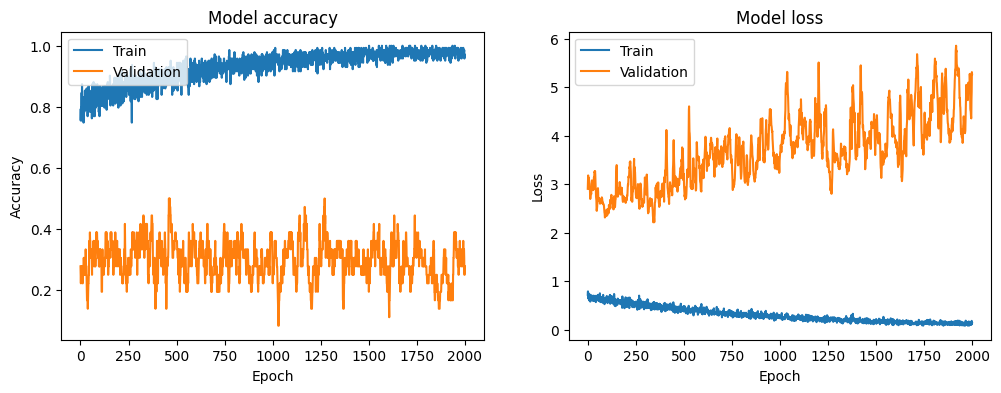

In [132]:
# Fungsi untuk plot history
def plot_history(history):
    # Plot akurasi
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history.get('val_accuracy', []))
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history.get('val_loss', []))
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Plot history
plot_history(history)

In [55]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [110]:
res = model.predict(X_test)

for i in range(len(res)):
    action_index = np.argmax(res[i])
    print(actions[action_index])

1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step

W0000 00:00:1718958152.716930    1176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
voice
to
language
translate
translate
translate
to
translate
language
this
i
you
see
this
and
sign
you
hello
voice
sign
translate
demonstrate
translate
translate
i
i
hello
sign
sign
to
hello
language
this
language
to
i


In [133]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
multilabel_confusion_matrix(ytrue, yhat)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


array([[[33,  0],
        [ 3,  0]],

       [[30,  0],
        [ 3,  3]],

       [[33,  1],
        [ 2,  0]],

       [[34,  2],
        [ 0,  0]],

       [[32,  0],
        [ 1,  3]],

       [[33,  0],
        [ 2,  1]],

       [[33,  2],
        [ 1,  0]],

       [[33,  0],
        [ 2,  1]],

       [[34,  0],
        [ 2,  0]],

       [[33,  0],
        [ 3,  0]],

       [[27,  6],
        [ 2,  1]],

       [[33,  0],
        [ 3,  0]],

       [[33,  3],
        [ 0,  0]],

       [[31,  5],
        [ 0,  0]],

       [[33,  3],
        [ 0,  0]],

       [[29,  4],
        [ 2,  1]]])

In [134]:
accuracy_score(ytrue, yhat)

0.2777777777777778

In [135]:
# Simpan model ke file HDF5
model.save('/kaggle/working/Model.h5')

In [ ]:
!pip install tensorflowjs

In [131]:
from tensorflowjs import converters

converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [136]:
# Simpan seluruh model Keras
model.save('/kaggle/working/my_model.keras')  

# Convert model to TensorFlow.js format
!tensorflowjs_converter --input_format=keras /kaggle/working/my_model.keras /kaggle/working/my_model_tfjs

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


2024-06-21 08:52:39.116358: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 08:52:39.116448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 08:52:39.117937: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Traceback (most recent call last):
  File "/opt/conda/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/opt/conda/lib/python3.10/site-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/opt/conda/lib/python3.10/site-packages/tensorflowjs/converters/converter.py", line 9

In [138]:
folder_name = '/kaggle/working/my_model_tfjs'

zip_file_name = '/kaggle/working/my_model_tfjs.zip'

create_zip(folder_name, zip_file_name)


folder_name = '/kaggle/working/tfjs_model'

zip_file_name = '/kaggle/working/tfjs_model.zip'

create_zip(folder_name, zip_file_name)